In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yaml

In [2]:
from catboost import CatBoostRegressor, CatBoostClassifier
from catboost import Pool
from sklearn.model_selection import  train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import shap
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

/root/anaconda3/envs/cp/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
def score_regression_simple(target, predictions,) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)

    metrics = {
        "R2":       round(r2_score(target, predictions),3),
        "MAE":  round(mean_absolute_error(target, predictions),3),
        "MSE":  round(mean_squared_error(target, predictions),3),
        "RMSE":   round((np.sqrt(mean_squared_error(target, predictions))),3),
        "MAPE":        round(mean_absolute_percentage_error(target, predictions),3),
        } 
    return metrics


def score_classifier_simple(target, predictions, threshold=0.5) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)
    response = (predictions > threshold).astype(int)

    metrics = {
        "roc_auc_score":   round((np.sqrt(roc_auc_score(target, predictions))),3),
        "av_precision_score": round((np.sqrt(average_precision_score(target, predictions))),3),
        "accuracy_score":  round(accuracy_score(target, response),3),
        "precision_score":  round(precision_score(target, response),3),
        "recall_score":   round((np.sqrt(recall_score(target, response))),3),
        "f1_score":       round(f1_score(target, response),3),
        "matthews_corrcoef":        round(matthews_corrcoef(target, response),3),
        } 
    return metrics

In [4]:
def calc_min_price_rolling(data, delta_h=24, features=None):
    if features is None:
        features = ['rarity', 'genesis', 'sneaker_type', 'level', 'mint']

    result = np.zeros(len(data))

    for i in range(len(data)):
        #i = 156
        sample = data.iloc[i]
        data_tmp = data.iloc[:i]
        data_tmp = data_tmp[data_tmp['date'] > (sample['date'] - pd.Timedelta(delta_h, unit='h'))]

        for feature in features:
            data_tmp = data_tmp[(data_tmp[feature] == sample[feature])]
        result[i] = data_tmp['price'].min()
    
    return result

# SETUP

In [5]:
CONFIG_DIR = '../app/'

In [6]:
with open(f"{CONFIG_DIR}config_prod.yml", 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.SafeLoader)

In [7]:
BD_NAME = f'{config["DATASET"]}.csv'
BD_FOLDER = './data'
VERSION = config["VERSION"]
START_DATE = '2022-09-03'
TETS_DATE = '2022-09-18'

In [8]:
data_quality_expected_range_dict = {
    'sneaker':
        {
        #'is_type': {'genesis': bool},
        'is_in':
            {
            'rarity': ['common', 'uncommon', 'rare'],
            'sneaker_type': ['ranger', 'sprinter', 'hiker', 'coacher'],
            },
        'min_max':
            {
            'level': [0, 30],
            'base_performance': [0, 40],
            'base_fortune': [0, 40],
            'base_joy': [0, 40],
            'base_durability': [0, 40],
            'performance': [0, 500],
            'fortune': [0, 300],
            'joy': [0, 300],
            'durability': [0, 300],
            'mint': [0, 7],
            'buy_count_12H': [0, 500],
            'buy_count_24H': [0, 1000],
            'sell_count_24H': [0, 2000],
            'cancel_count_24H': [0, 1000],
            'token_all_activity_3H': [0, 30],
            'token_sell_activity_6H': [0, 30],
            },
        }
}

# DATA

In [9]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')
data

Columns (67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.


,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
0,1663834915,36599,47848,sell,0x7a4c0c70e5c7713c9ccec9e06165cf6cd3b95745,NaN,0.80,sneakers,common,sprinter,...,460.0,8295.0,27652,7165,546,3375,5989,10689,85.0,1.233051
1,1663834906,36598,24713,sell,0x85b9fc6c95536608e5a7c2fe4f4b6af97c2df12c,NaN,0.90,sneakers,common,hiker,...,459.0,8295.0,27652,8349,546,3375,5989,10689,85.0,1.228814
2,1663834867,36597,31960,sell,0x7a4c0c70e5c7713c9ccec9e06165cf6cd3b95745,NaN,0.79,sneakers,common,hiker,...,458.0,8295.0,27652,8349,546,3375,5990,10689,85.0,1.228814
3,1663834864,36325,24713,cancel,0x85b9fc6c95536608e5a7c2fe4f4b6af97c2df12c,NaN,NaN,sneakers,common,hiker,...,459.0,8295.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,85.0,1.224576
4,1663834819,36596,16146,sell,0x053b7806258249892ddd1e636c472d9f34568be0,NaN,0.80,sneakers,common,sprinter,...,459.0,8295.0,27652,7165,546,3375,5991,10690,85.0,1.229787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45381,1661029606,13798,24335,sell,0x0d4eafe1ed97f590fde02c21dcf2b0ae6cb106d7,NaN,0.90,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
45382,1661029594,13797,27211,sell,0xb83b40609684191abba9184f627a112df5ac0a44,NaN,0.92,sneakers,common,hiker,...,NaN,NaN,15935,4223,257,4546,5226,15935,NaN,NaN
45383,1661029585,13596,32513,buy,0x1041f11e1738c5ea8d3ff3c5a1a314a617313ee1,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.92,box,common,NaN,...,NaN,NaN,904,0,252,1495,1831,2314,NaN,NaN
45384,1661029462,13796,32779,sell,0x668ff3191878ed0f7112031305eccb1d79a865e4,NaN,1.00,sneakers,common,sprinter,...,NaN,NaN,15934,3984,256,4545,5225,15934,NaN,NaN


In [10]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [11]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45386 entries, 0 to 45385
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  32394 non-null  float64
 1   time_ownership             32394 non-null  float64
 2   wallet_box_mint            32394 non-null  float64
 3   wallet_sneaker_mint        32394 non-null  float64
 4   time_level_up              29578 non-null  float64
 5   time_level_up_for_mint     32394 non-null  float64
 6   base_mint_price_amt        32394 non-null  float64
 7   base_mint_price_azy        32394 non-null  float64
 8   base_mint_price_bnb        22371 non-null  float64
dtypes: float64(9)
memory usage: 3.1 MB


In [12]:
data.genesis

0        False
1         True
2        False
3         True
4         True
         ...  
45381     True
45382    False
45383    False
45384    False
45385     True
Name: genesis, Length: 45386, dtype: bool

In [13]:
data = data[(data.item_type == 'sneakers') & (data.event == 'buy')].copy()
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
9,1663834672,36092,51606,buy,0x54385cd24f09b80af920459000caf4c08724974f,0x19a582543526319fde8466c87f066f729fb6e31b,1.38,sneakers,common,coacher,...,458.0,8295.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,84.0,1.229787
23,1663833955,36376,46863,buy,0x85332bf920e4f55b05e4183759b12bf9b0f38543,0x5ee49bad73c49d4ad744b69139418e30520c7368,0.83,sneakers,common,coacher,...,455.0,8297.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,84.0,1.236052
27,1663833898,36550,52303,buy,0xf3119222fefd46875391333ed596246194717f70,0x17a5d62acfd984b1629faeeb01df0124cee18037,2.80,sneakers,uncommon,hiker,...,457.0,8296.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,84.0,1.239316
28,1663833871,34250,25434,buy,0x78fdc989ad2f4ac5f5e6cd6c0221edc09c29f6c7,0x5ee49bad73c49d4ad744b69139418e30520c7368,1.20,sneakers,common,coacher,...,458.0,8296.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,84.0,1.234043
29,1663833856,36540,53924,buy,0x5168861770ed9dcfb21bead5efbbe6916f3fbd8b,0xb6b72b725dc59f0f2523000d5f548cd61632dde6,0.85,sneakers,common,sprinter,...,459.0,8296.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,84.0,1.238298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45323,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
45346,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
45360,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
45365,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


# data_quality

In [14]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    for element in data[feature].unique():
        if element not in dq[feature]:
            print(f'{feature} not in data_quality_expected_range_dict. get {element}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    if data[feature].min() < dq[feature][0]:
        print(f'{feature} less then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

    if data[feature].max() > dq[feature][1]:
        print(f'{feature} more then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

In [15]:
data['mint'].isna().sum()

0

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8665 entries, 9 to 45379
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        8665 non-null   int64  
 1   mrk_id                                           8665 non-null   int64  
 2   token_id                                         8665 non-null   int64  
 3   event                                            8665 non-null   object 
 4   wallet_from                                      8665 non-null   object 
 5   wallet_to                                        8665 non-null   object 
 6   price                                            8665 non-null   float64
 7   item_type                                        8665 non-null   object 
 8   rarity                                           8665 non-null   object 
 9   sneaker_type                 

In [17]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8665 entries, 9 to 45379
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  8665 non-null   float64
 1   time_ownership             8665 non-null   float64
 2   wallet_box_mint            8665 non-null   float64
 3   wallet_sneaker_mint        8665 non-null   float64
 4   time_level_up              8665 non-null   float64
 5   time_level_up_for_mint     8665 non-null   float64
 6   base_mint_price_amt        8665 non-null   float64
 7   base_mint_price_azy        8665 non-null   float64
 8   base_mint_price_bnb        6275 non-null   float64
dtypes: float64(9)
memory usage: 677.0 KB


In [18]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
9,1.657801e+09,44592.0,5.0,4.0,0.0,1800.0,300.0,200.0,0.661129
23,1.657829e+09,13914.0,7.0,7.0,900.0,1800.0,300.0,200.0,0.660348
27,1.657870e+09,1412.0,11.0,14.0,900.0,1800.0,1200.0,800.0,2.640983
28,1.657801e+09,179947.0,9.0,9.0,900.0,1800.0,300.0,200.0,0.660246
29,1.657800e+09,1970.0,13.0,13.0,0.0,1800.0,300.0,200.0,0.660246
...,...,...,...,...,...,...,...,...,...
45323,1.657803e+09,18915.0,5.0,0.0,900.0,1800.0,300.0,200.0,NaN
45346,1.657800e+09,5178.0,6.0,10.0,900.0,1800.0,300.0,200.0,NaN
45360,1.657800e+09,446391.0,5.0,7.0,900.0,1800.0,300.0,200.0,NaN
45365,1.659970e+09,1062034.0,0.0,1.0,2700.0,1800.0,300.0,200.0,NaN


In [19]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [20]:
#int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint']
#float_columns = ['performance', 'fortune', 'joy', 'durability', 'price']
#cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [21]:
#for columns in int_columns:
#    data[columns] = data[columns].astype('int')

# for columns in float_columns:
#     data[columns] = data[columns].astype('float')

#for columns in cat_columns:
#    data[columns] = data[columns].astype('category')

In [22]:
#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8665 entries, 9 to 45379
Data columns (total 75 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        8665 non-null   int64  
 1   mrk_id                                           8665 non-null   int64  
 2   token_id                                         8665 non-null   int64  
 3   event                                            8665 non-null   object 
 4   wallet_from                                      8665 non-null   object 
 5   wallet_to                                        8665 non-null   object 
 6   price                                            8665 non-null   float64
 7   item_type                                        8665 non-null   object 
 8   rarity                                           8665 non-null   object 
 9   sneaker_type                 

In [24]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_waller_buyer,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis
9,1663834672,36092,51606,buy,0x54385cd24f09b80af920459000caf4c08724974f,0x19a582543526319fde8466c87f066f729fb6e31b,1.38,sneakers,common,coacher,...,458.0,8295.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,84.0,1.229787
23,1663833955,36376,46863,buy,0x85332bf920e4f55b05e4183759b12bf9b0f38543,0x5ee49bad73c49d4ad744b69139418e30520c7368,0.83,sneakers,common,coacher,...,455.0,8297.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,84.0,1.236052
27,1663833898,36550,52303,buy,0xf3119222fefd46875391333ed596246194717f70,0x17a5d62acfd984b1629faeeb01df0124cee18037,2.80,sneakers,uncommon,hiker,...,457.0,8296.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,84.0,1.239316
28,1663833871,34250,25434,buy,0x78fdc989ad2f4ac5f5e6cd6c0221edc09c29f6c7,0x5ee49bad73c49d4ad744b69139418e30520c7368,1.20,sneakers,common,coacher,...,458.0,8296.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,84.0,1.234043
29,1663833856,36540,53924,buy,0x5168861770ed9dcfb21bead5efbbe6916f3fbd8b,0xb6b72b725dc59f0f2523000d5f548cd61632dde6,0.85,sneakers,common,sprinter,...,459.0,8296.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,84.0,1.238298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45323,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,15972,3657,275,4576,5258,15972,NaN,NaN
45346,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,15954,4077,261,4559,5240,15954,NaN,NaN
45360,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,15942,4226,253,4552,5230,15942,NaN,NaN
45365,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,15938,4073,253,4548,5228,15938,NaN,NaN


In [25]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

In [26]:
data[data.duplicated(['token_id', 'item_type', 'rarity', 'sneaker_type', 'level', 'mint',])]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_holder,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis,date
44890,1661076949,14027,23846,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0x7bdf18948f2b640ba7fea97875849038bd43da2c,0.73,sneakers,common,sprinter,...,NaN,16182,4070,391,4746,5443,16182,NaN,NaN,2022-08-21 10:15:49
44839,1661079343,14070,20408,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0x7dd69ca014565e2c9e1b47beabf57a4469d51fe1,0.73,sneakers,common,sprinter,...,NaN,16191,4072,387,4748,5448,16191,NaN,NaN,2022-08-21 10:55:43
44636,1661087557,14094,26385,buy,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,0x06333746416b07371d84d1f862a352ec7ca1ab10,1.16,sneakers,common,hiker,...,NaN,16227,4332,384,4770,5469,16227,NaN,NaN,2022-08-21 13:12:37
44441,1661095945,14208,16352,buy,0xec04f1a68a3618028f3431ccf570508d95d34dce,0x3ae4020278e724bec4d24135bf9d42b6879a648f,0.69,sneakers,common,sprinter,...,NaN,16258,4083,380,4791,5492,16258,NaN,NaN,2022-08-21 15:32:25
43710,1661155769,14662,31425,buy,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0xf1a560df54f04b45e756d1cb36241fec633134a2,0.70,sneakers,common,sprinter,...,NaN,16415,4126,251,4875,5592,16415,NaN,NaN,2022-08-22 08:09:29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,1663816172,36258,48495,buy,0x0027fbc35ce9bc0fdb938367c034ed4b993515a5,0x69097a0d86eb043f6e1612d157ea7d7127c14762,1.00,sneakers,common,ranger,...,8292.0,27570,7675,500,3342,6089,10657,88.0,1.252174,2022-09-22 03:09:32
465,1663817876,35709,47414,buy,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0xa78879bac8220a404621e173e8746a105aa36c54,2.44,sneakers,uncommon,ranger,...,8292.0,27579,7677,506,3349,6078,10665,87.0,1.244635,2022-09-22 03:37:56
377,1663821761,36402,40624,buy,0x1866a2122826437d1de06cfea730ed4e50a57cc4,0x626d11d87adda0bec5e7147e19b4d755ba13551a,0.75,sneakers,common,hiker,...,8295.0,27599,8330,520,3361,6055,10681,86.0,1.192308,2022-09-22 04:42:41
178,1663829650,35656,42985,buy,0x590fcd78396caac0596c6a4d19898b19f374785b,0x43cb5cc5dfbe71339a6a12cd689d770435ca0f4d,0.78,sneakers,common,sprinter,...,8293.0,count_sneaker,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,84.0,1.178261,2022-09-22 06:54:10


In [27]:
#len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

In [28]:
#train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()

# ML

## FE

In [29]:
#data['min_price_by_rarity_genesis_type_level_mint_24H_nan'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].isna()
#data['min_price_by_rarity_genesis_type_24H_nan'] = data['min_price_by_rarity_genesis_type_24H'].isna()

#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']

In [30]:
data['token_sell_activity_6H'].max()

11

In [31]:
data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(np.nan)
data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(np.nan)

In [32]:
# Перекуп датасет

dupl_df = data[data.duplicated(['token_id', 'item_type', 'rarity', 'sneaker_type', 'level', 'mint',], keep=False)]

In [33]:
data[data['token_id'] == 34874]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_sneaker_type,count_new_sneaker_1d,count_new_sneaker_7d,count_new_sneaker_14d,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis,date,sum_activity_24H,sells_activity_24H
30226,1662138884,21406,34874,buy,0x92ede55a13c314bc7ca513734240d5d751b73008,0xa9343304ac2e9e45c0470e1ece4ca37c9774ce51,1.07,sneakers,common,coacher,...,3942,323,1584,4052,13161,NaN,NaN,2022-09-02 17:14:44,1654,1.869180
25988,1662430561,23510,34874,buy,0xa9343304ac2e9e45c0470e1ece4ca37c9774ce51,0x3273af210822c44afd7254510e612e4dbb1040a7,0.97,sneakers,common,coacher,...,4018,287,2007,3803,9987,NaN,NaN,2022-09-06 02:16:01,1079,2.341772


In [34]:
len(dupl_df)

2060

In [35]:
count_list = []
final_df = pd.DataFrame()

for token_id in dupl_df['token_id'].unique():
    data_tmp = dupl_df[dupl_df['token_id'] == token_id]
    #if data_tmp.iloc[0]['wallet_to'] == data_tmp.iloc[1]['wallet_from']:
    #print(len(data_tmp))
    i=0
    #for i in range(len(data_tmp)-1):
        #print(i)
    sample = data_tmp.iloc[i].copy()
    sample['sell_wallet_from'] = data_tmp.iloc[i+1]['wallet_from']
    sample['sell_price'] = data_tmp.iloc[i+1]['price']
    sample['sell_data'] = data_tmp.iloc[i+1]['date']
    sample['profit'] = (data_tmp.iloc[i+1]['price'] - ((data_tmp.iloc[i+1]['price']/100) * 5)) - data_tmp.iloc[i]['price']
    final_df = pd.concat([final_df, sample], ignore_index=True, sort=False, axis=1)
    
    #break

In [36]:
final_df = final_df.T
final_df

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,count_new_sneaker_30d,count_box_mrk_all,ratio_sneaker_genesis,date,sum_activity_24H,sells_activity_24H,sell_wallet_from,sell_price,sell_data,profit
0,1661065858,13953,31752,buy,0x8109ddb2277068a597cc9511e94f288b4f72e36c,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0.76,sneakers,common,sprinter,...,16155,NaN,NaN,2022-08-21 07:10:58,911,4.683168,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0.9,2022-09-02 20:03:07,0.095
1,1661069971,13988,23846,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.5,sneakers,common,sprinter,...,16168,NaN,NaN,2022-08-21 08:19:31,908,4.256881,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:15:49,0.1935
2,1661070010,13991,20408,buy,0xa080c839f04044eef1574e234ab5b0063d2e01c1,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,0.5,sneakers,common,sprinter,...,16169,NaN,NaN,2022-08-21 08:20:10,910,4.227273,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0.73,2022-08-21 10:55:43,0.1935
3,1661079088,14089,26385,buy,0x25ad8afeb7b5c119fdbabb2ec99f84a611caea2a,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,0.8,sneakers,common,hiker,...,16191,NaN,NaN,2022-08-21 10:51:28,978,4.469027,0xa068379c563f7db21cc9c378a0f2a92ee64af7ed,1.16,2022-08-21 13:12:37,0.302
4,1661082994,14081,26390,buy,0x627afb1341cb1ae3cb3546424709dba42d88bde9,0xd96fcc51a852767af7a599a5bdf2daf0f162627b,0.72,sneakers,common,sprinter,...,16204,NaN,NaN,2022-08-21 11:56:34,998,4.557522,0xd96fcc51a852767af7a599a5bdf2daf0f162627b,0.7,2022-08-29 16:25:54,-0.055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,1663774445,35889,28548,buy,0xdb3ee008a369b866b86a2e3d6dcd7f7edb2306e5,0x3273af210822c44afd7254510e612e4dbb1040a7,0.88,sneakers,common,coacher,...,10689,90.0,1.355769,2022-09-21 15:34:05,1881,3.459375,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.99,2022-09-21 18:04:18,0.0605
942,1663779184,35946,28203,buy,0xec164fe62d61831c37b2ff573f9c4927d8ca0e78,0x2ae93028294c98a2e6ccfc0d7f743ac42588e090,0.71,sneakers,common,hiker,...,10662,88.0,1.324074,2022-09-21 16:53:04,1871,3.531847,0x2ae93028294c98a2e6ccfc0d7f743ac42588e090,0.75,2022-09-21 17:49:45,0.0025
943,1663780663,35965,26164,buy,0x84353a1ddd6521e3fef66bc9c08080585c3196e2,0xae9dbe3feb9fd03945ed79f79142e8787fe47907,0.75,sneakers,common,sprinter,...,10654,88.0,1.286996,2022-09-21 17:17:43,1888,3.565079,0xae9dbe3feb9fd03945ed79f79142e8787fe47907,0.89,2022-09-21 17:33:08,0.0955
944,1663781140,35968,55051,buy,0x3a2967f4a5a81858707770d5baea2e8c6301885b,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.89,sneakers,common,ranger,...,10643,88.0,1.283784,2022-09-21 17:25:40,1895,3.529781,0x2b2f9ed8123c058c6f69cac2ab603ee5cb46d50c,0.99,2022-09-21 17:43:06,0.0505


In [37]:
final_df.profit.median()

0.029750000000000054

In [38]:
final_df.profit.sum()

10.235224999999998

In [39]:
len(final_df.groupby('wallet_to')['profit'].sum())

295

In [40]:
(final_df.groupby('wallet_to')['profit'].sum().sort_values() > 0).sum()

146

In [41]:
(final_df.groupby('wallet_to')['profit'].sum().sort_values() > 1).sum()

14

In [42]:
final_df.groupby('wallet_to')['profit'].sum().sort_values()

wallet_to
0xe58ea7792930a4b52b4b4701b88ec709b205c54d   -8.459425
0xee17c73127c83d876758f8750fd4c81710673d2b     -7.3965
0x4a37b679463b90481547956da5b0432d45c867a5      -6.836
0x5eddc3624cf47c37eb7f056ab23150e502341d0a     -6.8065
0xda9f0564c09479c9c54e653b05c47bfe663952a6        -5.2
                                                ...   
0xee731ff68f1b70358d4220eb964ed39feb89c6d9       2.417
0xff06dbe17724093ce542247b28beef42dedb9f4b      4.3415
0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba       4.604
0xf3df1c64cb2e66400ef968caabfbe665457d25d4      7.7085
0x3273af210822c44afd7254510e612e4dbb1040a7     17.1795
Name: profit, Length: 295, dtype: object

In [43]:
(final_df.wallet_to.value_counts() > 1).sum()

116

In [44]:
# фильтр по количеству сделок
len(final_df.wallet_to.value_counts()[final_df.wallet_to.value_counts() > 10])

9

In [45]:
select_wallets = final_df.wallet_to.value_counts()[final_df.wallet_to.value_counts() > 10].index
final_df = final_df[final_df.wallet_to.isin(select_wallets)].copy()

In [46]:
len(final_df)

338

In [47]:
# фильтр только прибыльных торгошей
final_df.groupby('wallet_to')['profit'].sum()[final_df.groupby('wallet_to')['profit'].sum() > 2].sort_values()

wallet_to
0xff06dbe17724093ce542247b28beef42dedb9f4b     4.3415
0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba      4.604
0x3273af210822c44afd7254510e612e4dbb1040a7    17.1795
Name: profit, dtype: object

In [48]:
select_wallets = final_df.groupby('wallet_to')['profit'].sum()[final_df.groupby('wallet_to')['profit'].sum() > 2].index
final_df = final_df[final_df.wallet_to.isin(select_wallets)].copy()
len(final_df)

204

In [49]:
final_df['sell_time'] = ((final_df['sell_data'] - final_df['date']) / np.timedelta64(1,'h')).astype(int)

In [50]:
final_df['sell_time']

52      51
55      57
76      32
77      11
79     136
      ... 
923     22
925      0
937     15
940      8
941      2
Name: sell_time, Length: 204, dtype: int64

In [51]:
final_df['target'] = final_df['profit']

In [52]:
final_df['target'].max()

0.8815

In [53]:
final_df['target'].min()

-2.6075000000000004

# Model

In [54]:
data = final_df.copy()

In [55]:
int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint', 'buy_count_12H',
    'buy_count_24H','sum_activity_24H','token_all_activity_3H',
    'token_sell_activity_6H','time_level_up']
float_columns = ['base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability', 'price', 'min_price_all_24H',
    'sells_activity_24H',
    'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    'min_price_by_rarity_genesis_type_level_mint_72H',
    'min_price_by_rarity_genesis_type_24H','profit', 
    'base_mint_price_amt',
    'base_mint_price_azy', 
    'base_mint_price_bnb',
    'price_bnb', 
    'price_azy', 
    'price_amt',
    'target']
cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [56]:
for columns in int_columns:
    data[columns] = data[columns].astype('int')

for columns in float_columns:
    data[columns] = data[columns].astype('float')

for columns in cat_columns:
    data[columns] = data[columns].astype('category')

In [57]:
data['genesis'] = data['genesis'].astype('bool')

In [58]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)
predict_price = model.predict(data[model.feature_names_])
predict_price = np.round(predict_price, 3)
data['predict'] = predict_price
#predict_price

iteritems is deprecated and will be removed in a future version. Use .items instead.


In [59]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(data[model.feature_names_])
predict_price = np.round(predict_price, 2)
data['predict_base'] = predict_price

iteritems is deprecated and will be removed in a future version. Use .items instead.


In [60]:
data['profit_by_predict_model'] = np.round((data['predict'] - ((data['predict']/100) * 5)) - data['price'], 3)

In [61]:
data['profit_by_predict_base_model'] = np.round((data['predict_base'] - ((data['predict_base']/100) * 5)) - data['price'], 3)

In [62]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,sum_activity_24H,sells_activity_24H,sell_wallet_from,sell_price,sell_data,profit,sell_time,target,profit_by_predict_model,profit_by_predict_base_model
52,1661330758,15771,14732,buy,0x50246a336021f120dc42a694d574f6fa593c130f,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.70,sneakers,common,sprinter,...,938,3.081633,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.82,2022-08-26 12:24:47,0.0790,51,0.0790,0.176,0.202
55,1661342057,15841,24003,buy,0xbf4296b6e85d8aa032c091edf006bf5fe3f3b5b3,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.68,sneakers,common,sprinter,...,917,3.020000,0xff06dbe17724093ce542247b28beef42dedb9f4b,0.85,2022-08-26 21:45:51,0.1275,57,0.1275,0.196,0.222
76,1661438542,16446,15848,buy,0x8ddaeb2ecd2a4fc4e29e82067cd2d1d84649e544,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.67,sneakers,common,sprinter,...,895,3.089041,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.79,2022-08-26 23:28:36,0.0805,32,0.0805,0.120,0.137
77,1661438812,16448,36542,buy,0xa874128dc7703a2909ad89591ac684cf228f4ea1,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.79,sneakers,common,ranger,...,893,3.075342,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.89,2022-08-26 01:56:14,0.0555,11,0.0555,0.169,0.208
79,1661440348,16461,22239,buy,0x878cda24c1433184a8ea963fb1638c9fd35bfa8f,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.75,sneakers,common,hiker,...,876,2.952381,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.89,2022-08-31 07:52:29,0.0955,136,0.0955,0.050,0.096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923,1663701606,34924,54423,buy,0x7ae3fded637fcebb79a8b7282e743f3487a19e24,0x3273af210822c44afd7254510e612e4dbb1040a7,0.80,sneakers,common,ranger,...,1446,2.552239,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,1.02,2022-09-21 17:57:15,0.1690,22,0.1690,0.140,0.084
925,1663707592,35071,29439,buy,0x262346361e0f004e0c20a58b08ba883d18a7caf7,0x3273af210822c44afd7254510e612e4dbb1040a7,0.78,sneakers,common,coacher,...,1499,3.153584,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,0.97,2022-09-20 21:22:56,0.1415,0,0.1415,0.235,0.218
937,1663761776,35694,47414,buy,0xfec16099c6f01d9838032ec5f56fe53ffc2a0b9b,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,2.05,sneakers,uncommon,ranger,...,1947,3.373178,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,2.44,2022-09-22 03:37:56,0.2680,15,0.2680,0.137,0.221
940,1663768193,35814,16961,buy,0x221077507e0dc0957367754af9795c16db9ff683,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,1.09,sneakers,common,hiker,...,1963,3.516517,0xbfe1f3b2d7e2b5aaeaefc9e3a5e3f3da271793ba,1.29,2022-09-21 22:00:18,0.1355,8,0.1355,-0.029,0.117


In [63]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

132

In [64]:
data = data[(data.date >= START_DATE)].copy()
train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()
test_data = data[(data.date > TETS_DATE)].copy()

In [65]:
train_data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [66]:
train_data[['price_bnb', 'price_azy', 'price_amt', 'wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb', 'date']]

,price_bnb,price_azy,price_amt,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,date
460,276.798229,0.111966,0.519497,1659203035.0,1125777.0,2.0,3.0,60,1800.0,300.0,200.0,0.643943,2022-09-03 07:06:55
461,276.883697,0.111953,0.516913,1660744494.0,150.0,0.0,0.0,900,1800.0,300.0,200.0,0.640935,2022-09-03 07:33:34
464,276.171518,0.111510,0.521967,1659438695.0,216.0,3.0,3.0,900,1800.0,300.0,200.0,0.647758,2022-09-03 08:35:22
472,277.109304,0.099167,0.552721,1658162819.0,519011.0,7.0,10.0,900,1800.0,300.0,200.0,0.669951,2022-09-03 13:00:04
473,277.268066,0.100288,0.550715,1659438695.0,273.0,3.0,3.0,900,1800.0,300.0,200.0,0.668205,2022-09-03 13:18:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,275.461441,0.080994,0.552836,1662729948.0,89881.0,0.0,0.0,3300,1800.0,300.0,200.0,0.660889,2022-09-16 09:35:34
840,277.046354,0.080868,0.553509,1660834452.0,2072555.0,3.0,3.0,3960,1800.0,300.0,200.0,0.657747,2022-09-16 11:55:15
843,273.582605,0.083529,0.562362,1663069583.0,181191.0,0.0,0.0,2700,1800.0,300.0,200.0,0.677727,2022-09-16 19:13:28
845,273.715741,0.083369,0.561111,1658445000.0,3405319.0,13.0,22.0,900,1800.0,300.0,200.0,0.675910,2022-09-16 20:18:31


In [67]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132 entries, 460 to 862
Data columns (total 86 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   timestamp                                        132 non-null    int64         
 1   mrk_id                                           132 non-null    int64         
 2   token_id                                         132 non-null    int64         
 3   event                                            132 non-null    object        
 4   wallet_from                                      132 non-null    object        
 5   wallet_to                                        132 non-null    object        
 6   price                                            132 non-null    float64       
 7   item_type                                        132 non-null    category      
 8   rarity                                

In [68]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    #'wallet_from_buy_count',
    #'wallet_from_all_count',
    'level',
    # 'base_performance',
    # 'base_fortune',
    # 'base_joy',
    # 'base_durability',
    # 'performance',
    # 'fortune',
    # 'joy',
    # 'durability',
    'mint',
    #'buy_count_12H',
    #'buy_count_24H',
    #'min_price_all_24H',
    #'sum_activity_24H',
    #'sells_activity_24H',
    #'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    #'min_price_by_rarity_genesis_type_level_mint_72H',
    #'min_price_by_rarity_genesis_type_24H',
    #'min_price_by_rarity_genesis_type_48H',
    #'min_price_by_rarity_genesis_type_72H',
    #'token_all_activity_3H',
    #'token_sell_activity_6H',
    'price',
    #'sell_price',
    #'profit',
    #'time_level_up', 
    #'time_level_up_for_mint', 
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    #'base_mint_price_bnb',
    #'price_bnb', 
    #'price_azy', 
    #'price_amt',
    #'predict',
    #'predict_base',
    'profit_by_predict_model',
    'profit_by_predict_base_model',
    ]
cat_features = [0, 1, 2,]

In [69]:
X = data[features].copy().reset_index(drop=True)
y = data.target.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.target.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.target.copy().reset_index(drop=True)

In [70]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    model = CatBoostRegressor(
        depth=3,
        #learning_rate=0.01,
        #iterations=1000,
        loss_function='MAPE',
        random_seed=42
        )

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  2.90it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:00,  3.21it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:00,  3.28it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:01,  3.31it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:01,  3.33it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:01,  3.34it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:02,  3.36it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:02,  3.35it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:02,  3.35it/s]iteritems is deprec

In [71]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,-0.055,1.4720
MAE,0.084,0.0587
MSE,0.071,0.1672
RMSE,0.172,0.2068
MAPE,0.868,0.6409


In [72]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,-0.055,1.4720
MAE,0.084,0.0587
MSE,0.071,0.1672
RMSE,0.172,0.2068
MAPE,0.868,0.6409


In [73]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.074, 'MAE': 0.084, 'MSE': 0.071, 'RMSE': 0.267, 'MAPE': 0.867}

In [74]:
# Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


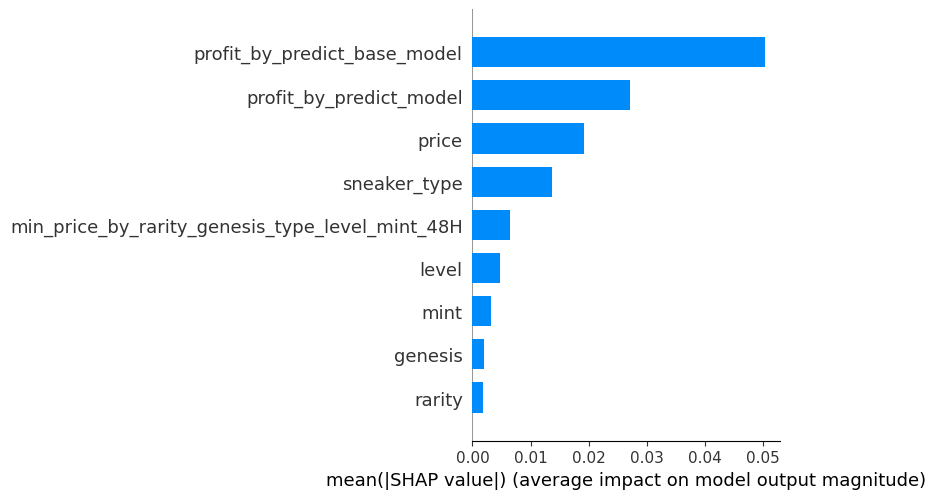

In [75]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## TEST

In [76]:
model = CatBoostRegressor(
    depth=3,
    #learning_rate=0.01,
    #iterations=1000,
    loss_function='MAPE',
    random_seed=42
    )

# Fit model 
model.fit(X_train, y_train, cat_features=cat_features,)
#model.save_model(f'./models/sneaker_model_{VERSION}.model')

0:	learn: 0.0973251	total: 627us	remaining: 627ms
1:	learn: 0.0960631	total: 1.36ms	remaining: 678ms
2:	learn: 0.0951370	total: 1.89ms	remaining: 629ms
3:	learn: 0.0941908	total: 2.46ms	remaining: 613ms
4:	learn: 0.0932852	total: 2.99ms	remaining: 594ms
5:	learn: 0.0923229	total: 3.5ms	remaining: 580ms
6:	learn: 0.0917920	total: 4.01ms	remaining: 568ms
7:	learn: 0.0910514	total: 4.45ms	remaining: 552ms
8:	learn: 0.0903438	total: 4.99ms	remaining: 550ms
9:	learn: 0.0894568	total: 5.46ms	remaining: 540ms
10:	learn: 0.0884497	total: 5.93ms	remaining: 534ms
11:	learn: 0.0878048	total: 6.38ms	remaining: 525ms
12:	learn: 0.0870475	total: 6.83ms	remaining: 518ms
13:	learn: 0.0865690	total: 7.31ms	remaining: 515ms
14:	learn: 0.0860825	total: 7.75ms	remaining: 509ms
15:	learn: 0.0856206	total: 8.12ms	remaining: 500ms
16:	learn: 0.0854929	total: 8.38ms	remaining: 484ms
17:	learn: 0.0847767	total: 8.73ms	remaining: 476ms
18:	learn: 0.0841805	total: 9.04ms	remaining: 467ms
19:	learn: 0.0836619	tot

In [77]:
pred = model.predict(X_test)
pred = np.round(pred, 3)

score = score_regression_simple(y_test, pred,)
score

{'R2': 0.723, 'MAE': 0.087, 'MSE': 0.009, 'RMSE': 0.095, 'MAPE': 0.569}

In [78]:
submission = pd.DataFrame()
submission['profit'] = test_data.profit.copy().reset_index(drop=True)
submission['pred'] = pred

In [79]:
submission.profit.sum()

2.2245

In [80]:
submission

,profit,pred
0,0.2355,0.135
1,0.1460,0.080
2,0.3680,0.210
3,0.7005,0.628
4,0.1690,0.086
5,0.1415,0.251
6,0.2680,0.263
7,0.1355,0.208
8,0.0605,0.175


In [81]:
submission[submission['pred'] > 0.05].profit.sum()

2.2245

In [82]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': 0.725, 'MAE': 0.087, 'MSE': 0.009, 'RMSE': 0.095, 'MAPE': 0.575}

## Fit full Model

In [83]:
X = data[features].copy().reset_index(drop=True)
y = data.target.copy().reset_index(drop=True)

model = CatBoostRegressor(
    depth=3,
    #learning_rate=0.01,
    #iterations=1000,
    loss_function='MAPE',
    random_seed=42
    )

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_profit_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


0:	learn: 0.1008171	total: 608us	remaining: 608ms
1:	learn: 0.0998425	total: 1.13ms	remaining: 564ms
2:	learn: 0.0988024	total: 1.63ms	remaining: 542ms
3:	learn: 0.0978483	total: 2.14ms	remaining: 534ms
4:	learn: 0.0968981	total: 2.62ms	remaining: 521ms
5:	learn: 0.0960272	total: 3.1ms	remaining: 514ms
6:	learn: 0.0951932	total: 3.59ms	remaining: 509ms
7:	learn: 0.0943990	total: 4.05ms	remaining: 502ms
8:	learn: 0.0932348	total: 4.47ms	remaining: 492ms
9:	learn: 0.0924822	total: 4.93ms	remaining: 488ms
10:	learn: 0.0917576	total: 5.3ms	remaining: 476ms
11:	learn: 0.0910177	total: 5.72ms	remaining: 471ms
12:	learn: 0.0902849	total: 6.13ms	remaining: 466ms
13:	learn: 0.0892054	total: 6.54ms	remaining: 461ms
14:	learn: 0.0885756	total: 6.88ms	remaining: 452ms
15:	learn: 0.0879116	total: 7.26ms	remaining: 446ms
16:	learn: 0.0872441	total: 7.63ms	remaining: 441ms
17:	learn: 0.0867941	total: 7.89ms	remaining: 431ms
18:	learn: 0.0862669	total: 8.2ms	remaining: 423ms
19:	learn: 0.0855050	total

In [84]:
y

0      0.0770
1      0.0455
2      0.1740
3      0.3305
4      0.0685
        ...  
136    0.1690
137    0.1415
138    0.2680
139    0.1355
140    0.0605
Name: target, Length: 141, dtype: float64

### Test

In [85]:
i=102

In [86]:
sneaker_dict = {}

features = data.columns

for feature in features:
    sneaker_dict[feature] = data.iloc[i][feature]

sneaker_dict['sum_activity_24H'] = sneaker_dict['buy_count_24H'] + sneaker_dict['sell_count_24H'] + sneaker_dict['cancel_count_24H']
sneaker_dict['sells_activity_24H'] = sneaker_dict['sell_count_24H'] / sneaker_dict['buy_count_24H']

sneaker_dict

{'timestamp': 1663062245,
 'mrk_id': 28652,
 'token_id': 29213,
 'event': 'buy',
 'wallet_from': '0x05a1a11f5f0bfcf97d9813f07f813e92547032cb',
 'wallet_to': '0x3273af210822c44afd7254510e612e4dbb1040a7',
 'price': 0.75,
 'item_type': 'sneakers',
 'rarity': 'common',
 'sneaker_type': 'ranger',
 'level': 5,
 'base_performance': 2.0,
 'base_fortune': 4.6,
 'base_joy': 3.6,
 'base_durability': 6.3,
 'performance': 18.0,
 'fortune': 7.1,
 'joy': 5.6,
 'durability': 9.3,
 'mint': 2,
 'parent1': 10413.0,
 'parent2': nan,
 'genesis': True,
 'parent1_sneaker_type': nan,
 'parent2_sneaker_type': nan,
 'price_bnb': 293.08693043,
 'price_azy': 0.08820386,
 'price_amt': 0.54663499,
 'wallet_from_buy_count': 0,
 'wallet_from_all_count': 1,
 'token_all_activity_3H': 1,
 'token_sell_activity_6H': 1,
 'buy_count_12H': 61,
 'buy_count_24H': 288,
 'buy_count_48H': 524,
 'sell_count_12H': 223,
 'sell_count_24H': 680,
 'sell_count_48H': 1223,
 'cancel_count_12H': 115,
 'cancel_count_24H': 421,
 'cancel_coun

In [87]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] not in dq[feature]:
        print(f'{feature} not in data_quality_expected_range_dict. get {sneaker_dict[feature]}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] < dq[feature][0]:
        print(f'{feature} less then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][0]}')

    if sneaker_dict[feature] > dq[feature][1]:
        print(f'{feature} more then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][1]}')

In [88]:
pd.Series(sneaker_dict)[model.feature_names_]

rarity                                             common
sneaker_type                                       ranger
genesis                                              True
level                                                   5
mint                                                    2
min_price_by_rarity_genesis_type_level_mint_48H      0.69
price                                                0.75
profit_by_predict_model                             0.044
profit_by_predict_base_model                        0.057
dtype: object

In [89]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_profit_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

sample = pd.Series(sneaker_dict)
predict_price = model.predict(sample[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

0.046

In [90]:
data.iloc[i]['profit']

0.019500000000000073

iteritems is deprecated and will be removed in a future version. Use .items instead.


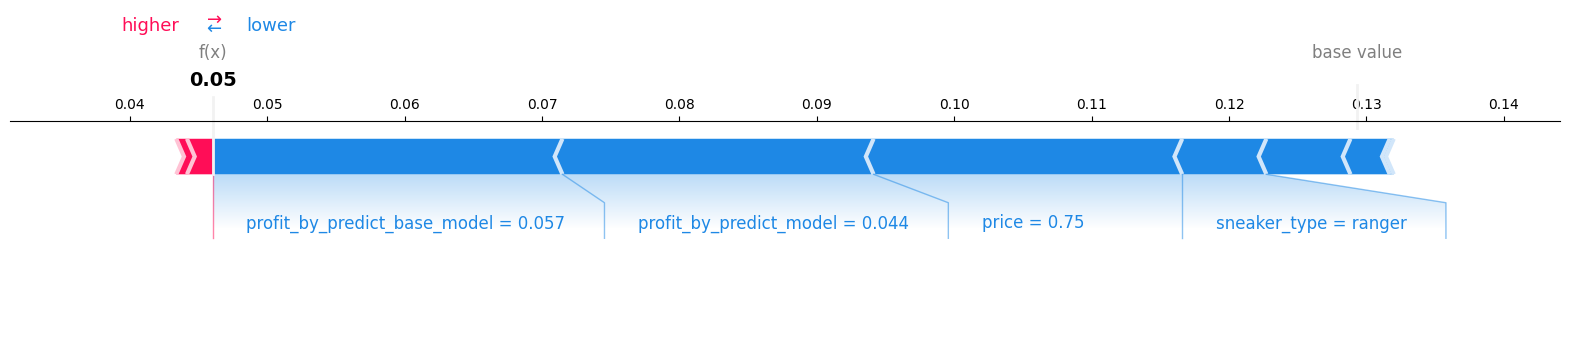

In [91]:
sample = pd.Series(sneaker_dict)
sample = pd.DataFrame(sample[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)